## Import the required libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

from keras import layers
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers import Input, Flatten, merge, Lambda, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers.wrappers import TimeDistributed, Bidirectional
from keras.utils import np_utils, to_categorical
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers.normalization import BatchNormalization

from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedShuffleSplit,StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

import matplotlib.pyplot as plt
import itertools

from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.utils import shuffle

import re

## Load the dataset

In [2]:
data = pd.read_csv("trainset.csv")
comments = data['Komenti']
y = data['Sentimenti']

## Input parameters

In [3]:
MAX_SEQUENCE_LENGTH = 20
MAX_NB_WORDS = 6000
EMBEDDING_DIM = 300

## Data preprocessing

In [4]:
def preprocess_text(sen):

    sentence = sen
    # Remove everything except a-z, A-Z, + sign and chars like Ë, ë, Ç, ç
    sentence = re.sub('[^a-zA-Z0-9\+ËëÇç]', ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

### Fill list with preprocessed text

In [5]:
docs = []
for sen in comments:
    docs.append(preprocess_text(sen))

## Encode class values as integers 

In [6]:
encoder = LabelEncoder()

encoder.fit(y) # encoder.fit([1, 1, 2, 6]) LabaleEncoder()
# encoder.classes_ 
# array([1, 2, 6])

# In our case
# encoder.classes_   
# array([0, 1, 2], dtype=int64)

encoded_y = encoder.transform(y)
# array([0, 0, 1, 2]...)

# encoder.inverse_transform([0, 0, 1, 2])
# array([1, 1, 2, 6])

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)
# Converts a class vector(integers) to binary class matrix.
# E.g. for use with categorical_crossentropy.
# Arguments: 
    # y: class vector to be converted into a matrix(integers from 0 to num_classes)
    # Returns a binary matrix representation of the input. The classes axis is placed last
# Example:
    # a = tf.keras.utils_to_categorical([0, 1, 2, 3], num_classes=4)
    # a = tf.constant(a, shape=[4, 4])
    # print(a)
# tf.Tensor(
# [[1. 0. 0. 0.]
#  [0. 1. 0. 0.]
#  [0. 0. 1. 0.]
#  [0. 0. 0. 1.]], shape = (4,4), dtype=float32)

## Define plot_history function

In [7]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1) # range(1, 251) 
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

## Define full_multiclass_report which prints classification report

In [8]:
## If binary (sigmoid output), set binary parameter to True
def full_multiclass_report(model,
                           x,
                           y_true,
                           classes,
                           batch_size = 16,
                           binary=False):

    # 1. Transform one-hot encoded y_true into their class number
    if not binary:
        y_true = np.argmax(y_true,axis=1)
    
    # 2. Predict classes and stores in y_pred
    y_pred = model.predict_classes(x, batch_size=batch_size)
    
    # 3. Print accuracy score
    print("Accuracy : "+ str(accuracy_score(y_true,y_pred)))
    
    print("")
    
    # 4. Print classification report
    print("Classification Report")
    print(classification_report(y_true,y_pred,digits=4))    

## Create a tokenizer

In [9]:
tokenizer = Tokenizer(nb_words=MAX_NB_WORDS, lower=True )

tokenizer.fit_on_texts(docs)

sequences = tokenizer.texts_to_sequences(docs)

word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

# convert text to sequence of tokens and pad them to ensure equal length vectors 
x = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

Found 6123 unique tokens.


In [10]:
x

array([[   0,    0,    0, ...,   70,    1,  608],
       [   0,    0,    0, ...,  102,   48, 2144],
       [1302,    2,  729, ...,   24,  609, 2148],
       ...,
       [   0,    0,    0, ...,   58,    5,  324],
       [   0,    0,    0, ..., 1530, 1298,   43],
       [   0,    0,    0, ...,    0,    0,    0]])

## Training, testing and validation

In [11]:
seed = 20

x_train, x_test, y_train, y_test = train_test_split(x, dummy_y, train_size=0.8, random_state=seed)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.7, random_state=seed)

In [21]:
print(len(x_train))
print(len(x_val))
print(len(x_test))
print(len(x_train) + len(x_val) + len(x_test))

803
345
287
1435


## Generate same results if you don't change parameters

In [12]:
from numpy.random import seed

seed(1)

# from tensorflow import set_random_seed
import tensorflow as tf

# set_random_seed(2)
tf.random.set_seed(2)

## Build LSTM Model

In [13]:
LSTM_model = Sequential()

LSTM_model.add(Embedding(len(word_index), EMBEDDING_DIM, input_length =x.shape[1]))

LSTM_model.add(LSTM(32))

LSTM_model.add(Dense(32,activation='relu'))
LSTM_model.add(Dense(3,activation='softmax'))

LSTM_model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 20, 300)           1836900   
_________________________________________________________________
lstm (LSTM)                  (None, 32)                42624     
_________________________________________________________________
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 1,880,679
Trainable params: 1,880,679
Non-trainable params: 0
_________________________________________________________________
None


## Evaluate model

In [14]:
LSTMHistory=LSTM_model.fit(x_train, y_train, epochs = 100, batch_size = 16,verbose=2, 
                           validation_data=(x_val,y_val), shuffle=True)

Epoch 1/100
51/51 - 2s - loss: 1.0121 - accuracy: 0.5093 - val_loss: 0.9433 - val_accuracy: 0.5449
Epoch 2/100
51/51 - 1s - loss: 0.8332 - accuracy: 0.6364 - val_loss: 0.8865 - val_accuracy: 0.5797
Epoch 3/100
51/51 - 1s - loss: 0.4781 - accuracy: 0.8269 - val_loss: 0.9359 - val_accuracy: 0.6029
Epoch 4/100
51/51 - 1s - loss: 0.1680 - accuracy: 0.9552 - val_loss: 1.1641 - val_accuracy: 0.6435
Epoch 5/100
51/51 - 1s - loss: 0.0586 - accuracy: 0.9838 - val_loss: 1.3422 - val_accuracy: 0.6319
Epoch 6/100
51/51 - 1s - loss: 0.0258 - accuracy: 0.9925 - val_loss: 1.6436 - val_accuracy: 0.6348
Epoch 7/100
51/51 - 1s - loss: 0.0221 - accuracy: 0.9925 - val_loss: 1.6772 - val_accuracy: 0.6232
Epoch 8/100
51/51 - 1s - loss: 0.0142 - accuracy: 0.9975 - val_loss: 1.7645 - val_accuracy: 0.6377
Epoch 9/100
51/51 - 1s - loss: 0.0151 - accuracy: 0.9950 - val_loss: 1.8612 - val_accuracy: 0.6377
Epoch 10/100
51/51 - 1s - loss: 0.0118 - accuracy: 0.9963 - val_loss: 1.8609 - val_accuracy: 0.6406
Epoch 11/

51/51 - 1s - loss: 0.0024 - accuracy: 0.9975 - val_loss: 2.7296 - val_accuracy: 0.6290
Epoch 84/100
51/51 - 1s - loss: 0.0026 - accuracy: 0.9988 - val_loss: 2.7069 - val_accuracy: 0.6348
Epoch 85/100
51/51 - 1s - loss: 0.0026 - accuracy: 0.9988 - val_loss: 2.7350 - val_accuracy: 0.6319
Epoch 86/100
51/51 - 1s - loss: 0.0022 - accuracy: 0.9975 - val_loss: 2.7596 - val_accuracy: 0.6319
Epoch 87/100
51/51 - 1s - loss: 0.0025 - accuracy: 0.9988 - val_loss: 2.7517 - val_accuracy: 0.6348
Epoch 88/100
51/51 - 1s - loss: 0.0023 - accuracy: 0.9988 - val_loss: 2.7685 - val_accuracy: 0.6348
Epoch 89/100
51/51 - 1s - loss: 0.0025 - accuracy: 0.9988 - val_loss: 2.8240 - val_accuracy: 0.6290
Epoch 90/100
51/51 - 1s - loss: 0.0024 - accuracy: 0.9988 - val_loss: 2.7798 - val_accuracy: 0.6348
Epoch 91/100
51/51 - 1s - loss: 0.0022 - accuracy: 0.9975 - val_loss: 2.7926 - val_accuracy: 0.6348
Epoch 92/100
51/51 - 1s - loss: 0.0023 - accuracy: 0.9975 - val_loss: 2.8433 - val_accuracy: 0.6319
Epoch 93/100


In [17]:
help(LSTM_model.fit)

Help on method fit in module tensorflow.python.keras.engine.training:

fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1, max_queue_size=10, workers=1, use_multiprocessing=False) method of tensorflow.python.keras.engine.sequential.Sequential instance
    Trains the model for a fixed number of epochs (iterations on a dataset).
    
    Arguments:
        x: Input data. It could be:
          - A Numpy array (or array-like), or a list of arrays
            (in case the model has multiple inputs).
          - A TensorFlow tensor, or a list of tensors
            (in case the model has multiple inputs).
          - A dict mapping input names to the corresponding array/tensors,
            if the model has named inputs.
          - A `tf.data` dataset. Should return

## Print results

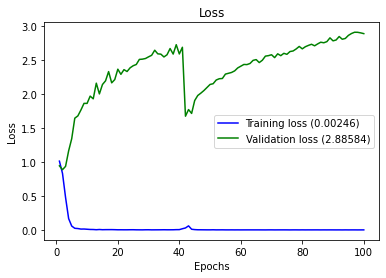

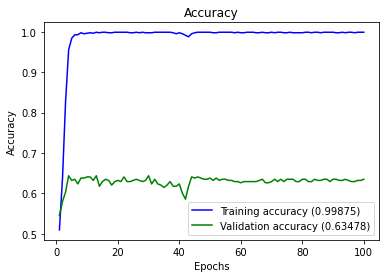

In [15]:
plot_history(LSTMHistory)

In [16]:
full_multiclass_report(LSTM_model, x_val, y_val, encoder.inverse_transform(np.arange(3)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Accuracy : 0.6347826086956522

Classification Report
              precision    recall  f1-score   support

           0     0.6390    0.8462    0.7281       182
           1     0.5600    0.3684    0.4444        38
           2     0.6456    0.4080    0.5000       125

    accuracy                         0.6348       345
   macro avg     0.6149    0.5409    0.5575       345
weighted avg     0.6327    0.6348    0.6142       345

